In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
import gensim
import logging

# Exploring the data

In [24]:
train_data = pd.read_csv('data/train_data.csv')
train_data.head()

,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,NaN
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,NaN
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,NaN
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,NaN
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,NaN


In [25]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323164 entries, 0 to 323163
Data columns (total 4 columns):
id              323164 non-null int64
question1       323163 non-null object
question2       323161 non-null object
is_duplicate    0 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.9+ MB


In [26]:
train_data.shape

(323164, 4)

In [27]:
train_labels = pd.read_csv('data/train_labels.csv')
train_labels.head()

,id,is_duplicate
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [28]:
train_labels.shape

(323164, 2)

In [29]:
train_data.id = train_labels.id
train_data.is_duplicate = train_labels.is_duplicate

In [30]:
train_data.head()

,id,question1,question2,is_duplicate
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 323164 entries, 0 to 323163
Data columns (total 4 columns):
id              323164 non-null int64
question1       323163 non-null object
question2       323161 non-null object
is_duplicate    323164 non-null int64
dtypes: int64(2), object(2)
memory usage: 9.9+ MB


In [32]:
train_data.shape

(323164, 4)

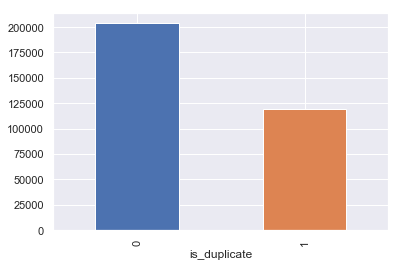

In [33]:
train_data.groupby(['is_duplicate'])['id'].count().plot.bar()

# Preprocessing the data

Create new columns for the dataframe representing the number of words in a sentence and the number of characters.

In [44]:
train_data['q1_words_count'] = df['question1'].str.split().str.len()
train_data['q2_words_count'] = df['question2'].str.split().str.len()

train_data['q1_char_count'] = df['question1'].str.len()
train_data['q2_char_count'] = df['question2'].str.len()

In [45]:
train_data.head()

,id,question1,question2,is_duplicate,q1_words_count,q2_words_count,q1_char_count,q2_char_count
0,0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14.0,12.0,66.0,57.0
1,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8.0,13.0,51.0,88.0
2,2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14.0,10.0,73.0,59.0
3,3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11.0,9.0,50.0,65.0
4,4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13.0,7.0,76.0,39.0


Select a subsample for training consisting of 2500 values

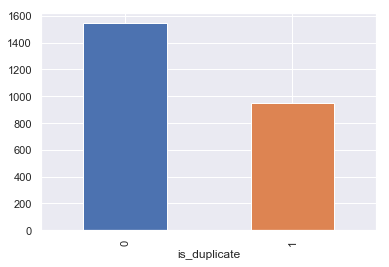

In [47]:
train_sample = train_data[0:2500]
train_sample.groupby('is_duplicate')['id'].count().plot.bar()

In [50]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                   level=logging.INFO)

Note: 
- Use word2vec for representation of words then calculate the average vector for all words in every sentence and use cosine similarity between vectors

- Remove stop words by using NLTK stop words. Use doc2vec to find similar sentences after training.

Doc2vec (aka paragraph2vec, aka sentence embeddings) modifies the word2vec algorithm to unsupervised learning of continuous representations for larger blocks of text, such as sentences, paragraphs or entire documents.

# Try fuzzywuzzy here

In [51]:
from fuzzywuzzy import fuzz

In [61]:
q1 = train_sample['question1'][4]
q2 = train_sample['question2'][4]
print(q1, '\n', q2)

Which one dissolve in water quikly sugar, salt, methane and carbon di oxide? 
 Which fish would survive in salt water?


In [62]:
fuzz.ratio(q1, q2)

45

In [63]:
train_sample['fuzz'] = fuzz.ratio(
    train_sample['question1'], train_sample['question2'])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [66]:
q1_list = train_sample['question1'].values
q2_list = train_sample['question2'].values

(2500,)